In [ ]:
!pip install presidio_analyzer
!pip install presidio_anonymizer

In [ ]:
!python -m spacy download en_core_web_lg

In [1]:
from presidio_analyzer import AnalyzerEngine, PatternRecognizer
from presidio_anonymizer import AnonymizerEngine
from presidio_anonymizer.entities import OperatorConfig

import requests
import os

import pandas as pd
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import tempfile
import webbrowser

In [3]:
notebook_path = os.path.abspath("BigData-Anonymizer.ipynb")

In [4]:
analyzer = AnalyzerEngine()
anonymizer = AnonymizerEngine()

In [5]:
entities_to_anonymize = ["PHONE_NUMBER", "PERSON", "LOCATION", "EMAIL_ADDRESS"]

In [6]:
def get_percentage_df(replaced_entity_amount, all_replaced_count):
    percentage_list = [round(amount / all_replaced_count * 100, 2) for amount in replaced_entity_amount]
    return pd.DataFrame(percentage_list, index=entities_to_anonymize, columns=["Percentage"])

In [7]:
def get_entity_type(analyzer_result):
    return analyzer_result.split(', ')[0].replace('type: ', '')

In [8]:
def calculate_replaced_entity_amount(analyzer_results):
    amount_list = [0] * len(entities_to_anonymize)
    for analyzer_result in analyzer_results:
        entity_index = entities_to_anonymize.index(get_entity_type(str(analyzer_result)))
        amount_list[entity_index] += 1
    return amount_list

In [9]:
def open_html(html):
    with tempfile.NamedTemporaryFile('w', delete=False, suffix='.html', encoding='utf-8') as f:
        url = 'file://' + f.name
        f.write(html)
    webbrowser.open_new_tab(url)

In [10]:
def analyze_and_anonymize(text_to_anonymize):
    analyzer_results = analyzer.analyze(
        text=text_to_anonymize,
        entities=entities_to_anonymize,
        language='en')
    anonymized_results = anonymizer.anonymize(
        text=text_to_anonymize,
        analyzer_results=analyzer_results,    
        operators={"DEFAULT": OperatorConfig("replace", {"new_value": "!ANONYMIZED!"})})
    return analyzer_results, anonymized_results

In [11]:
def analyze_and_anonymize_html(link):
    page = requests.get(link)
    text_to_anonymize = page.text
    open_html(text_to_anonymize)
    
    analyzer_results, anonymized_html = analyze_and_anonymize(text_to_anonymize)
    
    replaced_entity_amount = calculate_replaced_entity_amount(analyzer_results)
    sns.barplot(x=entities_to_anonymize, y=replaced_entity_amount)
    
    print(get_percentage_df(replaced_entity_amount, len(analyzer_results)))
    
    open_html(anonymized_html.text)

## Anonymize text example

In [12]:
values_to_anonymize_txt_count = 15

In [13]:
text_file_path = os.path.join(os.path.dirname(notebook_path), 'textExample.txt')

In [14]:
with open(text_file_path, 'r') as file:
    txt_to_anonymize = file.read()

In [15]:
analyzer_results_txt, anonymized_txt = analyze_and_anonymize(txt_to_anonymize)

In [16]:
replaced_entity_amount_txt = calculate_replaced_entity_amount(analyzer_results_txt)

<AxesSubplot:>

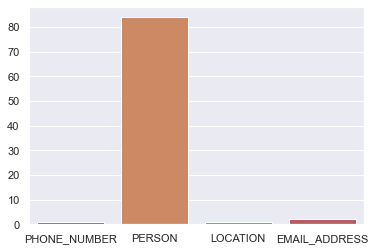

In [17]:
sns.barplot(x=entities_to_anonymize, y=replaced_entity_amount_txt)

In [18]:
print("Процент определенных персональных данных: {0} %".format(len(analyzer_results_txt) / values_to_anonymize_txt_count * 100))

Процент определенных персональных данных: 586.6666666666666 %


In [19]:
get_percentage_df(replaced_entity_amount_txt, len(analyzer_results_txt))

,Percentage
PHONE_NUMBER,1.14
PERSON,95.45
LOCATION,1.14
EMAIL_ADDRESS,2.27


Рассотрим анонимизацию текстовых данных. В качестве примера для эксперимента был выбран текст, сгенерированный сервисом https://ru.lipsum.com/, который не несет в себе определенной смысловой нагрузки. В данный текст были дополнительно добавлены персональные данные для рассмотрения, такие как номер телефона, имя и фамилия человека, адрес и адрес электронной почты (в общей сложности 15 данных, которые точно можно отнести к персональным).
Как видно из графика, алгоритм определил значительно больше персональных данных, чем изначально их содержалось в тексте. Такая погрешность вызвана тем, что многие данные были отнесены к имени человека. Так как текст генерируется на основе классического текста Lorem Ipsum, возможно, действильно многие данные похожи на имена.

## Anonymize html example

In [20]:
values_to_anonymize_html_count = 10

In [21]:
html_file_path = os.path.join(os.path.dirname(notebook_path), 'htmlExample.html')

In [22]:
with open(html_file_path, 'r') as file:
    html_to_anonymize = file.read()

In [23]:
open_html(html_to_anonymize)

In [24]:
analyzer_results_html, anonymized_html = analyze_and_anonymize(html_to_anonymize)

In [25]:
replaced_entity_amount_html = calculate_replaced_entity_amount(analyzer_results_html)

<AxesSubplot:>

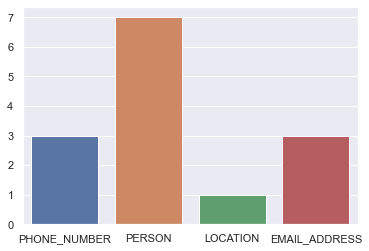

In [26]:
sns.barplot(x=entities_to_anonymize, y=replaced_entity_amount_html)

In [27]:
print("Процент определенных персональных данных: {0} %".format(len(analyzer_results_html) / values_to_anonymize_html_count * 100))

Процент определенных персональных данных: 140.0 %


In [28]:
get_percentage_df(replaced_entity_amount_html, len(analyzer_results_html))

,Percentage
PHONE_NUMBER,21.43
PERSON,50.00
LOCATION,7.14
EMAIL_ADDRESS,21.43


In [29]:
open_html(anonymized_html.text)

Рассмотрим анонимизацию данных на html странице. На страницу было добавлено 10 персональных данных с типами номер телефона, имя и фамилия человека, адрес и адрес электронной почты. Как видно из графика алгоритм отнес бОльшее количество данных к персональным, чем число действительно имеющихся на странице. Если рассмотреть итоговую html страницу с замененными данными, то можно увидеть, что некоторые из персональных данных не были скрыты. Также была нарушена структура html, так как некоторые теги были интерепретированы как персональные данные и были заменены. 

## Anonymize html pages

In [32]:
links = [
    'https://en.wikipedia.org/wiki/Joseph_Brodsky',
    'https://ikeamuseum.com/en/contact/',
    'https://www.coca-colacompany.com/company/history',
    'https://www.fragrancenet.com/help/aboutus',
    'https://authordylanhearn.wordpress.com/2017/02/13/bookblogger-bashing-in-the-end-youre-only-hurting-yourself-mondayblogs/',
    'https://www.legalnomads.com/about/',
    'https://expertvagabond.com/about/',
    'https://www.nomadicmatt.com/about-matt/',
    'https://pinchofyum.com/about',
    'https://weworewhat.com/pages/about'
]

               Percentage
PHONE_NUMBER         0.32
PERSON              79.12
LOCATION            20.56
EMAIL_ADDRESS        0.00


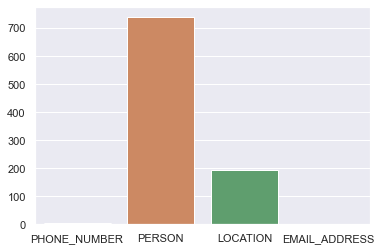

In [33]:
analyze_and_anonymize_html(links[0])

               Percentage
PHONE_NUMBER         3.60
PERSON              33.33
LOCATION            46.85
EMAIL_ADDRESS       16.22


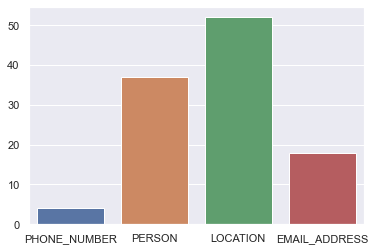

In [34]:
analyze_and_anonymize_html(links[1])

               Percentage
PHONE_NUMBER         0.00
PERSON              77.66
LOCATION            22.34
EMAIL_ADDRESS        0.00


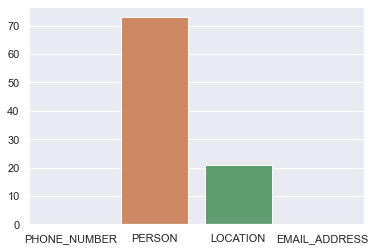

In [36]:
analyze_and_anonymize_html(links[2])

               Percentage
PHONE_NUMBER        21.78
PERSON              69.31
LOCATION             6.93
EMAIL_ADDRESS        1.98


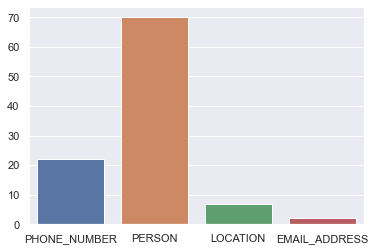

In [37]:
analyze_and_anonymize_html(links[3])

               Percentage
PHONE_NUMBER        15.66
PERSON              79.29
LOCATION             5.05
EMAIL_ADDRESS        0.00


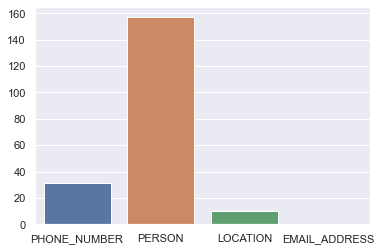

In [38]:
analyze_and_anonymize_html(links[4])

               Percentage
PHONE_NUMBER        10.26
PERSON              74.17
LOCATION            15.56
EMAIL_ADDRESS        0.00


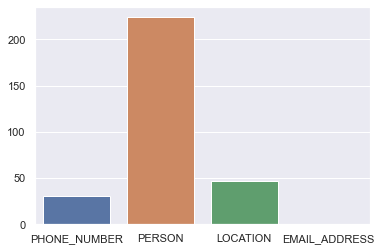

In [41]:
analyze_and_anonymize_html(links[5])

               Percentage
PHONE_NUMBER        20.50
PERSON              62.34
LOCATION            17.15
EMAIL_ADDRESS        0.00


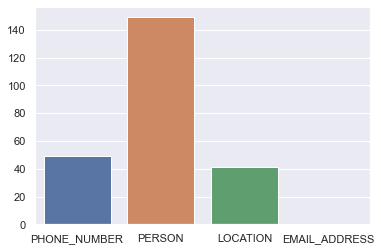

In [43]:
analyze_and_anonymize_html(links[6])

               Percentage
PHONE_NUMBER        10.14
PERSON              81.16
LOCATION             7.73
EMAIL_ADDRESS        0.97


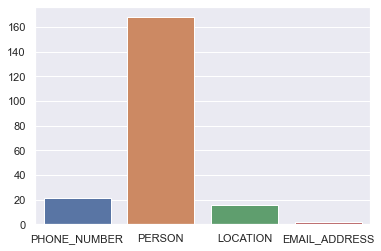

In [44]:
analyze_and_anonymize_html(links[7])

               Percentage
PHONE_NUMBER         8.06
PERSON              84.98
LOCATION             6.59
EMAIL_ADDRESS        0.37


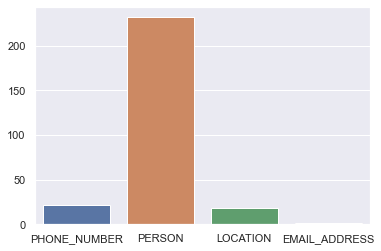

In [46]:
analyze_and_anonymize_html(links[8])

In [ ]:
analyze_and_anonymize_html(links[9])

При применении алгоритма на html страницах из интернета, также сильно нарушается структура html, теряется применение стилей, соответственно алгоритм относит неперсональные данные к персональным.
На графиках с количеством персональных данных по категориям можно заметить, что алгоритм делает неплохое разбиение проанализированных данных по типам. Например, в статье из Википедии отсутствовали адреса электронной почты и номера телефонов, что и отражено на графике. Также на странице с контактами компании солержится большое количество адресов и адресов электронной почты. На страницах взятых из личных блогов людей наибольшее количество персональных данных относится к типу имени и фамилии человека. 

Несмотря на то, что алгоритм показывает хорошие результаты на примерах из официальной документации, его применение для html страниц можно поставить под сомнение, ввиду проведенных экспериментов. Алгоритм изменяет структуру html кода, что приводит к изменению верстки и потери применяемых стилей.